# Code Exploration

In [1]:
# let's make sure requirements are up to date
!pip install -r requirements.txt


In [2]:
from omni import Benchmark

In [3]:
i = Benchmark(name="TestBenchmark")
print(i.name)

TestBenchmark


# Benchmark Definition
Let's use the infamous Iris Benchmark for reference. This is just a particular topology for a Benchmark. We define it in `iris-benchmark.yaml`. Do note that the orchestrator `.gitlab-ci.yaml` can be dynamically generated from only the info contained here.


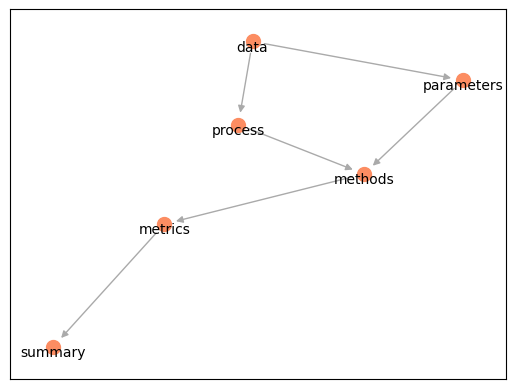

In [6]:
BENCHMARK_FILE='iris-benchmark.yaml'

from bench import build_dag_from_definition, plot_graph

g = build_dag_from_definition(BENCHMARK_FILE)
plot_graph(g)


Ok, now let's try to build a state machine to know when can we proceed to the next step...

In [203]:
from transitions import Machine, EventData
from functools import partial

class StateMachine:
    done = set([])
    
    def done_state(self, state):
        """
        done_state marks a state done from the outside
        """
        self.done.add(state)
    
    @classmethod
    def on_exit_state(self, event: EventData):
        """
        on_exit_state is used on internal transitions
        """
        exited = event.transition.source
        print(f"exited: {exited}")
        self.done.add(exited)

    @classmethod
    def on_enter_state(self, event: EventData):
        print(f"entered: {event.state._name}")


    def check_condition_for(graph, dest, event):
        print(f"check: {event.transition.dest}")
        conditions = set(list(graph.predecessors(dest)))
        if len(conditions) == 1:
            # a node with a single predecessor can only advance to a single state
            return True
        current = event.state._name
        can_transition = set(event.model.done).union(set([current])).intersection(conditions) == set(conditions)
        return can_transition


states = [{'name': node, 'on_exit': 'on_exit_state', 'on_enter': 'on_enter_state'} for node in g.nodes()]

# TODO: initial should be parsed from the yaml data tree (terminal too, this is validation)
machine = Machine(model=StateMachine, states=states, initial="data", send_event=True)

# Generate transitions based on DAG edges
for edge in g.edges:
    trigger_name = f'{edge[0]}_to_{edge[1]}'
    #print(trigger_name)
    transition = {'trigger': trigger_name, 'source': edge[0], 'dest': edge[1],
                  'conditions': partial(StateMachine.check_condition_for, g, edge[1])}
    machine.add_transition(**transition)

sm = StateMachine()

print("current:", sm.state)
sm.data_to_parameters()
assert(sm.state == "parameters")
sm.parameters_to_methods()
assert(sm.state == "parameters")
sm.done_state('process')
sm.parameters_to_methods()
assert(sm.state == "methods")
sm.methods_to_metrics()
assert(sm.state == "metrics")
sm.metrics_to_summary()
assert(sm.state == "summary")


current: data
check: parameters
exited: data
entered: parameters
check: methods
check: methods
exited: parameters
entered: methods
check: metrics
exited: methods
entered: metrics
check: summary
exited: metrics
entered: summary
